## PART 2: Detect sarcasm for headlines by training and tuning a Bidirectional LSTM model on New headlines for Sarcasm detection data.

In [55]:
#Import required libraries
from google.colab import drive
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import  Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,BatchNormalization,Dropout,Bidirectional,RNN,Input
from tensorflow.keras.optimizers import RMSprop,Adam, SGD
from keras.callbacks import ModelCheckpoint
import pandas as pd
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
import re
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import math

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from zipfile import ZipFile

with ZipFile('/content/drive/MyDrive/Great Learning/NLP/Assignment 11/glove.6B.zip') as z:
  z.extractall()

### Read and explore the data. Retain relevant columns

In [4]:
#open and read the json file
def parseJson(fname):
    for line in open(fname, 'r'):
        yield eval(line)

In [5]:
sarcasm_json= list(parseJson('/content/drive/MyDrive/Great Learning/NLP/Assignment 11/Sarcasm_Headlines_Dataset.json'))

In [6]:
sarcasm_df = pd.DataFrame()

In [7]:
#Convert the read json to Dataframe
for i in range(len(sarcasm_json)):
  sarcasm_df = sarcasm_df.append(pd.Series([sarcasm_json[i]['headline'],sarcasm_json[i]['is_sarcastic']]),ignore_index=True)
sarcasm_df.columns = ['headline', 'is_sarcastic']

In [8]:
sarcasm_df["is_sarcastic"] = sarcasm_df["is_sarcastic"].astype('int32')

In [11]:

print("Shape of the dataset :",sarcasm_df.shape)

Shape of the dataset : (26709, 2)


In [10]:
#Export to csv in order to use it in future.
sarcasm_df.to_csv('/content/drive/MyDrive/Great Learning/NLP/Assignment 11/Sarcasm_Headlines_Dataset.csv')

In [12]:
#Columns and datatypes
sarcasm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      26709 non-null  object
 1   is_sarcastic  26709 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 313.1+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


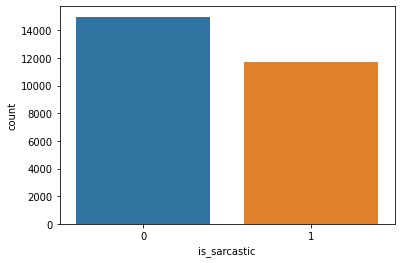

In [13]:
#Distribution of target column
sns.countplot(sarcasm_df['is_sarcastic'])

In [14]:
#From the countplot above, we can see that values for is_sarcastic is fairly balanced.
pd.Series(sarcasm_df['is_sarcastic']).value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

###  Get length of each sentence

In [15]:
#count of characters headlines
sarcasm_df['charlength']  = sarcasm_df['headline'].str.len()
#Count of words in headline
sarcasm_df['wordsLength']=  sarcasm_df['headline'].apply(lambda x: len(x.split()))

In [16]:
#Print dataframe with charlength and wordslength
sarcasm_df[:10]

,headline,is_sarcastic,charlength,wordsLength
0,former versace store clerk sues over secret 'b...,0,78,12
1,the 'roseanne' revival catches up to our thorn...,0,84,14
2,mom starting to fear son's web series closest ...,1,79,14
3,"boehner just wants wife to listen, not come up...",1,84,13
4,j.k. rowling wishes snape happy birthday in th...,0,64,11
5,advancing the world's women,0,27,4
6,the fascinating case for eating lab-grown meat,0,46,7
7,"this ceo will send your kids to school, if you...",0,67,14
8,top snake handler leaves sinking huckabee camp...,1,50,7
9,friday's morning email: inside trump's presser...,0,59,9


### Define parameters

In [18]:

max_word_freq = 20000    #the maximum number of words to keep, based on word frequency
max_len = 200          #Length for padding word sequences

###  Get indices for words

In [31]:
#Clean data
Words=[]

wnLemm = WordNetLemmatizer()
def cleanData(cleanTxt):
  cleanTxt=re.sub('[0-9]'," ",cleanTxt)
  cleanTxt=re.sub('[\'\"\.\,(){}]'," ",cleanTxt)
  cleanTxt=re.sub('[!@\*?:;#\$\%^&~]'," ",cleanTxt)
  cleanTxt=re.sub('[+-\/X*]'," ",cleanTxt)
  cleanTxt=re.sub('[\[\]=<>]'," ",cleanTxt)
  cleanTxt=re.sub('[<<>>_*]'," ",cleanTxt)
  cleanTxt=re.sub('[^a-zA-Z]'," ",cleanTxt)
  cleanTxt=cleanTxt.lower()
  #words_token = cleanTxt.split()
  #words = [wnLemm.lemmatize(word) for word in words_token  if not word  in set(stopwords.words('english'))] 
  #Words.extend(words)
  #words = " ".join(words)
  return cleanTxt

In [32]:
sarcasm_df['headlines_clean']=sarcasm_df['headline'].apply(cleanData)

In [33]:
features=sarcasm_df['headlines_clean']
labels= sarcasm_df['is_sarcastic']

In [36]:
#Vectorize the text corpus by converting them to sequence of numbers. Fit the features and get the indice/number associated with each word in the sequence
tokenizer = Tokenizer(num_words=max_word_freq,  lower=True, char_level=False, oov_token=None, document_count=0)
tokenizer.fit_on_texts(features)
sequences = tokenizer.texts_to_sequences(features)
#Pad the vectorized sequences to make them all of equal lengths
X_feat_seq = pad_sequences(sequences, truncating='post', maxlen=max_len)
vocab_size = len(tokenizer.word_index) + 1

In [39]:


#Print headlines and their vectorized form
for i in range(1,5):
  print("\ncleaned Headline :",features[i])
  print("Word indices : ",X_feat_seq[i])


cleaned Headline : the  roseanne  revival catches up to our thorny political mood  for better and worse
Word indices :  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0  

###  Create features and labels.Split them into 70:30 train-test ratio.

In [40]:
X_feat_seq     #Features
label_arr=np.array(labels)   #Labels

In [41]:
X_train,X_test,y_train,y_test=train_test_split(X_feat_seq,label_arr,random_state=42,test_size=0.30)

### 7. Create a weight matrix using GloVe embeddings

In [42]:
embeddings_index = dict()

#Read the pre-trained glove embeddings. For each line, each line containing the word and their embedding, take the coefficients and map it to their words in dictionary.

f = open('/content/glove.6B.50d.txt')

for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()

# create a weight matrix for words in headlines


In [46]:
embedding_matrix = np.zeros((vocab_size, 50))   #we have used 50 columns for zero matrix since the glove embedding matrix we have created above has 50 dimensions.

for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

### Define , compile and fit a Bidirectional LSTM model.Check the validation accuracy. 

In [73]:
#Define the model, compile and fit it. Calculate the validation accuracy. Return the fit model and validation accuracy.
def SarcasmLSTMModel(epoch):
  modelLSTM= Sequential()
  modelLSTM.add(Input(shape=(max_len) ))

  modelLSTM.add(Embedding(vocab_size,50,weights=[embedding_matrix],input_length=max_len))
  modelLSTM.add(Bidirectional(LSTM(128)))

  #modelNN.add(Bidirectional(LSTM(64,return_sequences=True)))
  modelLSTM.add(BatchNormalization())
  modelLSTM.add(Dropout(0.3))

  modelLSTM.add(Dense(128,activation='relu',kernel_initializer='glorot_normal'))
  modelLSTM.add(Dense(64,activation='relu',kernel_initializer='glorot_normal'))
  modelLSTM.add(BatchNormalization())
  modelLSTM.add(Dropout(0.3))

  modelLSTM.add(Dense(1,activation='sigmoid',kernel_initializer='glorot_normal'))
  checkpoint1 = ModelCheckpoint("/content/drive/MyDrive/Great Learning/NLP/Assignment 11/Sarcasm_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True)
  modelLSTM.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  history = modelLSTM.fit(X_train, y_train, batch_size=64, epochs=epoch, verbose=1,validation_split=0.2,callbacks=[checkpoint1])
  #acc=modelLSTM.evaluate(X_test,y_test)
 
  return modelLSTM

In [74]:
model= SarcasmLSTMModel(10)

Epoch 1/10
234/234 [==============================] - 178s 738ms/step - loss: 0.6583 - accuracy: 0.6726 - val_loss: 0.5276 - val_accuracy: 0.7757

Epoch 00001: val_accuracy improved from -inf to 0.77567, saving model to /content/drive/MyDrive/Great Learning/NLP/Assignment 11/Sarcasm_model.hdf5
Epoch 2/10
234/234 [==============================] - 172s 734ms/step - loss: 0.4397 - accuracy: 0.8015 - val_loss: 0.4760 - val_accuracy: 0.7882

Epoch 00002: val_accuracy improved from 0.77567 to 0.78824, saving model to /content/drive/MyDrive/Great Learning/NLP/Assignment 11/Sarcasm_model.hdf5
Epoch 3/10
234/234 [==============================] - 171s 730ms/step - loss: 0.3455 - accuracy: 0.8497 - val_loss: 0.3500 - val_accuracy: 0.8471

Epoch 00003: val_accuracy improved from 0.78824 to 0.84706, saving model to /content/drive/MyDrive/Great Learning/NLP/Assignment 11/Sarcasm_model.hdf5
Epoch 4/10
234/234 [==============================] - 171s 731ms/step - loss: 0.2907 - accuracy: 0.8787 - val

In [75]:
#Print the test accuracy
print("test set accuracy :",model.evaluate(X_test,y_test))

251/251 [==============================] - 23s 90ms/step - loss: 0.3881 - accuracy: 0.8722
test set accuracy : [0.38812756538391113, 0.8722076416015625]


In [76]:
#Predict  sarcastic detection for test set
predict=model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [77]:
#Convert the word indices to its word sentences for test set
X_test_texts= tokenizer.sequences_to_texts(X_test)

In [78]:
#Print Headline, the actual value for sarcasm and the predicted value for sarcasm.
print("Predictions ")
for i in range(100,120):
  print("\nStatement :", X_test_texts[i])
  print("\nAcutal Sarcasm value :",y_test[i])
  print("Predicted Sarcasm value :",predict[i][0])

Predictions 

Statement : teen runaway starts new high paying career

Acutal Sarcasm value : 1
Predicted Sarcasm value : 1

Statement : fcc votes to undo key roadblocks to media company consolidation

Acutal Sarcasm value : 0
Predicted Sarcasm value : 0

Statement : sniper school gets to have class on roof today

Acutal Sarcasm value : 1
Predicted Sarcasm value : 1

Statement : star wars fan all

Acutal Sarcasm value : 1
Predicted Sarcasm value : 0

Statement : reid warren meet with progressive groups ahead of looming government shutdown

Acutal Sarcasm value : 0
Predicted Sarcasm value : 0

Statement : california lt governor gavin newsom should run for president

Acutal Sarcasm value : 0
Predicted Sarcasm value : 0

Statement : apparently fire marshal wasn t just being a dick

Acutal Sarcasm value : 1
Predicted Sarcasm value : 0

Statement : new study finds solving every single personal problem reduces anxiety

Acutal Sarcasm value : 1
Predicted Sarcasm value : 1

Statement : a way to

### OBSERVATIONS/CONCLUSIONS:
1. For the sarcasm data, we were able to clean headline,create word embeddings using tokenizer from keras and associate indices for each word. We have created weight matrix to be fed to Bidirectional LSTM model using glove embeddings.We were able to train , tune and predict this model using several combinations of hyperparameters.
2. The accuracy achieved for the LSTM model to detect sarscam in headlines is 87.22%.
3. Out of 20 predicted values, model was able to correctly predict 18 values.